In [4]:
import pandas as pd
from collections import Counter, defaultdict
import matplotlib
import matplotlib.pyplot as plt
import pybedtools
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch, Rectangle, Arc
from biodata.delimited import DelimitedWriter
import biodataplot.genomeview as gv
import biodataplot.utils as bpu
from pathlib import Path

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [5]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/CRISPR_comparison/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# CRISPR data

In [6]:
inputfile = f"{PROJECT_DIR_s}resources/crispr_data/EPCrisprBenchmark_ensemble_data_GRCh38.tsv.gz"
df_info = pd.read_table(inputfile)
df_info.head(2)

,chrom,chromStart,chromEnd,name,EffectSize,chrTSS,startTSS,endTSS,measuredGeneSymbol,Significant,...,PowerAtEffectSize10,PowerAtEffectSize15,PowerAtEffectSize20,PowerAtEffectSize25,PowerAtEffectSize50,ValidConnection,CellType,Reference,Regulated,Dataset
0,chr1,3774714,3775214,CEP104|chr1:3691278-3691778:*,-0.293432,chr1,3857213.0,3857214.0,CEP104,True,...,NaN,NaN,NaN,0.825094,NaN,True,K562,Ulirsch2016,True,Nasser2021
1,chr1,3774714,3775214,LRRC47|chr1:3691278-3691778:*,-0.331178,chr1,3796503.0,3796504.0,LRRC47,True,...,NaN,NaN,NaN,0.608994,NaN,True,K562,Ulirsch2016,True,Nasser2021


In [7]:
df_info.columns

Index(['chrom', 'chromStart', 'chromEnd', 'name', 'EffectSize', 'chrTSS',
       'startTSS', 'endTSS', 'measuredGeneSymbol', 'Significant',
       'pValueAdjusted', 'PowerAtEffectSize10', 'PowerAtEffectSize15',
       'PowerAtEffectSize20', 'PowerAtEffectSize25', 'PowerAtEffectSize50',
       'ValidConnection', 'CellType', 'Reference', 'Regulated', 'Dataset'],
      dtype='object')

In [8]:
set(df_info["CellType"])

{'K562'}

In [9]:
# Get distance between P (TSS) and E (closer boundary)

distances = {}
for index, row in df_info.iterrows():
	tss = row["startTSS"]
	e_start = row["chromStart"]
	e_end = row["chromEnd"]
	if abs(e_start-tss) <= abs(e_end-tss):
		distances[row["name"]] = abs(e_start-tss)
	else:
		distances[row["name"]] = abs(e_end-tss)

In [10]:
# Data source

sorted(Counter(df_info["Reference"]).items(), key=lambda item: item[1], reverse=True)

[('Gasperini et al., 2019', 5355),
 ('Fulco2019', 3501),
 ('Schraivogel et al., 2020', 1306),
 ('Klann2017', 122),
 ('Fulco2016', 103),
 ('Huang2018', 7),
 ('Xie2017', 6),
 ('Ulirsch2016', 5),
 ('Wakabayashi2016', 3),
 ('Thakore2015', 2),
 ('Qi2018', 1),
 ('Xu2015', 1)]

In [11]:
# No. tested genes

len(set(df_info["measuredGeneSymbol"]))

2146

In [12]:
# No. tested enhancers

len(set([name.split("|")[1] for name in df_info["name"]]))

3962

In [13]:
# Confirm "Regulated" is a subset of "Significant"

len(df_info[df_info["Significant"]==True]), len(df_info[df_info["Regulated"]==True]), len(set(df_info[df_info["Significant"]==True]["name"]) & set(df_info[df_info["Regulated"]==True]["name"]))

(569, 487, 487)

In [14]:
# Significant but not regulated: gene expression increases after enhancer disruption

df_sig = df_info[(df_info["Significant"]==True)&(df_info["Regulated"]==False)]
min(df_sig["EffectSize"]), max(df_sig["EffectSize"])

(0.0016565925417555, 0.37107615)

In [15]:
# Get effect size of regulated P-E pairs

effects = {}
for index, row in df_info.iterrows():
	if not np.isnan(row["EffectSize"]):
		effects[row["name"]] = (row["Regulated"], row["EffectSize"])

# CRISPR validation of TREs

## CRIPSR regions vs. TREs

In [16]:
s = "C1"
ps = ["divergent", "unidirectional"]
d = "distal"

In [17]:
outputfile = f"{PROJECT_DIR_s}resources/crispr_data/EPCrisprBenchmark_ensemble_data_GRCh38.bed"
df_info.to_csv(outputfile, sep="\t", index=False, header=None)
b1 = pybedtools.BedTool(outputfile)

In [18]:
# Assign PROcap element to a CRISPR element (>50% TRE length)

mapping_all = {}
mapping_rev = defaultdict(set)
for p in ps:
	mapping_all[p] = defaultdict(set)
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed")
	# f: Minimum overlap required as a fraction of A
	overlap = b2.intersect(b1, wao=True, f=0.5)
	for i in overlap:
		if int(i.fields[-1]) > 0:
			procap_region = (i.fields[0], int(i.fields[1]), int(i.fields[2]))
			crispr_region = tuple(i.fields[8:11])
			pair, gene = i.fields[11], i.fields[16]
			# one crispr region can have > 1 target genes
			# different studies may test overlapping crispr regions
			mapping_all[p][procap_region].add((crispr_region, pair, gene))
			mapping_rev[crispr_region].add((procap_region, p))

In [19]:
len(mapping_rev), len([e for e in mapping_rev if len(mapping_rev[e]) > 1]), sum([len(mapping_rev[e]) for e in mapping_rev if len(mapping_rev[e]) > 1])

(1104, 34, 68)

In [20]:
# If one CRISPR region overlaps with > 1 TREs, remove this region

mapping = {}
for p in mapping_all:
	mapping[p] = defaultdict(set)
	for e in mapping_all[p]:
		for k in mapping_all[p][e]:
			if len(mapping_rev[k[0]]) == 1:
				mapping[p][e].add(k)

## 2.2 Effect size vs. distance

In [21]:
# Check the effect size and P-E distance
# Only focus on regulated elements
# If one element - gene pair is validated in multiple experiments, use the highest effect sizes

effects2 = defaultdict(dict)
tots = defaultdict(set)
for p in ps:
	for e in mapping[p]:
		if len(mapping[p][e]) > 0:
			for k in mapping[p][e]:
				crispr_region, pair, gene = k
				if pair in effects:
					tots[p].add((e, gene))
					if effects[pair][0]:
						if (e, gene) not in effects2[p] or abs(effects[pair][1]) > effects2[p][(e, gene)][0]:
							effects2[p][(e, gene)] = (effects[pair][1], pair)

In [22]:
for p in effects2:
	print(p, 
		  # No. unique elements mapped to CRISPR regions
		  len(set([k[0] for k in tots[p]])), 
		  # No. regulated pairs
		  len(effects2[p]), 
		  # No. unique elements in regulated pairs
		  len(set([k[0] for k in effects2[p]])),
		  # Proportion
		  len(set([k[0] for k in effects2[p]]))/len(set([k[0] for k in tots[p]]))
		 )

divergent 833 202 170 0.20408163265306123
unidirectional 202 26 23 0.11386138613861387


In [23]:
results = []
for p in ps:
	for e, gene in effects2[p]:
		effect, pair = effects2[p][(e,gene)]
		results.append([p.capitalize(), e, effect*100, distances[pair]/1000])
df_effect = pd.DataFrame(results)
df_effect.head(2)

,0,1,2,3
0,Divergent,"(chr1, 3774703, 3775204)",-33.117809,21.289
1,Divergent,"(chr1, 3774703, 3775204)",-47.201922,1.953


In [24]:
# No. target genes, No. TREs

len(df_effect[df_effect[0]=="Unidirectional"]), len(set(df_effect[df_effect[0]=="Unidirectional"][1]))

(26, 23)

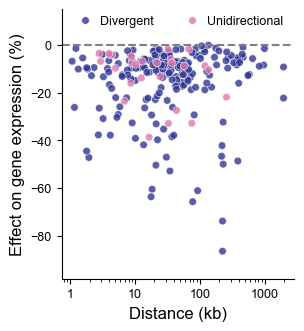

In [25]:
fig, ax = plt.subplots(figsize=(3,3.5))
g = sns.scatterplot(data=df_effect, x=3, y=2, 
					hue=0, palette=["#313695", "#de77ae"], 
					alpha=0.8, s=30, ax=ax)
g.spines[["right", "top"]].set_visible(False)

g.set_ylim([-98, 15])
g.set_ylabel("Effect on gene expression (%)", fontsize=bfontsize)

plt.xscale("log")
plt.xticks([1, 10, 100, 1000], ["1", "10", "100", "1000"])
g.set_xlabel("Distance (kb)", fontsize=bfontsize)

g.tick_params(labelsize=sfontsize)

g.axhline(y=0, ls="--", c="grey")

handles, labels = g.get_legend_handles_labels()
g.legend(loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=2, 
		 handletextpad=0.2, fontsize=sfontsize, frameon=False)

outputfile = f"{PROJECT_DIR_o}figures/Fig3c.pdf"
plt.savefig(outputfile, bbox_inches="tight", transparent=True)

# Examples

## Pick examples

In [26]:
e2g = {}
for p in ps:
	e2g[p] = defaultdict(set)
	for e, gene in effects2[p]:
		e2g[p][e].add(gene)

In [27]:
# Unidirectional elements with > 1 target genes

p = "unidirectional"
for e in e2g[p]:
	if len(e2g[p][e]) > 1:
		print(e, e2g[p][e])

('chr17', 32894199, 32894700) {'SPACA3', 'MYO1D', 'TMEM98'}
('chr5', 53118899, 53119400) {'CTD-2366F13.1', 'MOCS2'}


## Genomic position

In [28]:
e = ('chr17', 32894199, 32894700)
genes = {'MYO1D', 'TMEM98', 'SPACA3'}
pairs = [effects2[p][(e, gene)][-1] for gene in genes]

In [29]:
df_select = df_info[df_info["name"].isin(pairs)]
df_select

,chrom,chromStart,chromEnd,name,EffectSize,chrTSS,startTSS,endTSS,measuredGeneSymbol,Significant,...,PowerAtEffectSize10,PowerAtEffectSize15,PowerAtEffectSize20,PowerAtEffectSize25,PowerAtEffectSize50,ValidConnection,CellType,Reference,Regulated,Dataset
3380,chr17,32893739,32895015,MYO1D|chr17:31220757-31222033:*,-0.387,chr17,32877176.0,32877177.0,MYO1D,True,...,NaN,NaN,NaN,0.256838,NaN,True,K562,Huang2018,True,Nasser2021
3383,chr17,32893739,32895015,SPACA3|chr17:31220757-31222033:*,-0.328,chr17,32970376.0,32970377.0,SPACA3,True,...,NaN,NaN,NaN,0.198588,NaN,True,K562,Huang2018,True,Nasser2021
3385,chr17,32893739,32895015,TMEM98|chr17:31220757-31222033:*,-0.329,chr17,32927910.0,32927911.0,TMEM98,True,...,NaN,NaN,NaN,0.826891,NaN,True,K562,Huang2018,True,Nasser2021


In [30]:
# Same resource

set(df_select["Reference"])

{'Huang2018'}

In [31]:
# CRISPR region

crispr_region = list(df_select["chrom"])[0], list(df_select["chromStart"])[0], list(df_select["chromEnd"])[0]

In [32]:
# Range of effect size

min(df_select["EffectSize"]), max(df_select["EffectSize"])

(-0.387, -0.328)

In [33]:
# Get coordinates for genes

inputfile = f"{PROJECT_DIR_s}resources/genome_annotations/CollapsedGeneBounds.hg38.bed"
df_annot = pd.read_table(inputfile)
df_annot = df_annot[df_annot["name"].isin(genes)]
df_annot.head()

,#chr,start,end,name,score,strand,Ensembl_ID,gene_type
15994,chr17,32492521,32877173,MYO1D,0,-,ENSG00000176658,protein_coding
15995,chr17,32927909,32941649,TMEM98,0,+,ENSG00000006042,protein_coding
15996,chr17,32991863,32997877,SPACA3,0,+,ENSG00000141316,protein_coding


In [34]:
coordinates = {}
for index, row in df_annot.iterrows():
	chrom, start, end, gene, _, strand = row[:6]
	coordinates[gene] = (chrom, start, end, strand)

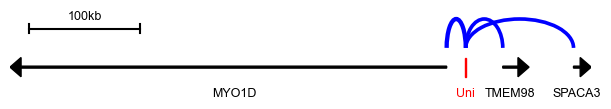

In [35]:
fig, ax = plt.subplots(figsize=(7.5,1))
ax.axis('off')
ax.set_xlim([np.min(df_annot["start"])-1e4,np.max(df_annot["end"])+1e4])
ax.set_ylim([0,8])

# Add ruler
x = 32500000
y = 6
ax.plot([x,x], [y-0.5,y+0.5], c="#000000")
ax.plot([x+1e5,x+1e5], [y-0.5,y+0.5], c="#000000")
ax.plot([x,x+1e5], [y,y], c="#000000")
ax.text(x+5e4, y+1, "100kb", fontsize=sfontsize, ha="center")

# Add enhancer
chrom, e_start, e_end = e
ax.add_patch(Rectangle((e_start, 1), e_end-e_start, 2, color="r"))
ax.text((e_end+e_start)//2, -1, "Uni", fontsize=sfontsize, ha="center", color="r")

for pair in pairs:
	effect = abs(effects[pair][1])
	mid = (e_end+e_start)//2
	
	# Add genes
	g = pair.split("|")[0]
	start, end, strand = coordinates[g][1:]
	if strand == "+":
		x = start
		dx = end-start
	else:
		x = end
		dx = start-end
	ax.arrow(x, 2, dx, 0, head_width=2, head_length=10000, width=0.2, color="#000000")
	ax.text((end+start)//2, -1, g, fontsize=sfontsize, style="italic", ha="center")

	# Add arcs
	if x < mid:
		anchor = x+abs(mid-x)/2
	else:
		anchor = x-abs(mid-x)/2
	ax.add_patch(Arc((anchor, 4), abs(mid-x), y, theta1=0.0, theta2=180, edgecolor='b', lw=8*effect))

outputfile = f"{PROJECT_DIR_o}figures/Fig3d.top.pdf"
plt.savefig(outputfile, bbox_inches="tight", transparent=True)

## Browser shot

In [36]:
crispr_bed = f"{PROJECT_DIR_o}temp/crispr_example.bed"
with DelimitedWriter(crispr_bed) as dw:
	chrom, start, end = crispr_region
	dw.write([chrom, start, end])

In [37]:
def plot_example(region, outputfile):
	data = {
			"PRO-cap (rep1)": [f"{PROJECT_DIR_d}Alignments/C1a_5pl.bw", f"{PROJECT_DIR_d}Alignments/C1a_5mn.bw"],
			"PRO-cap (rep2)": [f"{PROJECT_DIR_d}Alignments/C1b_5pl.bw", f"{PROJECT_DIR_d}Alignments/C1b_5mn.bw"],
			# "CRISPR": f"{PROJECT_DIR_o}temp/crispr_example.bed",
			"DNase": f"{PROJECT_DIR_r}ENCODE/ENCFF414OGC.bigWig",
			"H3K27ac": f"{PROJECT_DIR_r}ENCODE/ENCFF849TDM.bigWig"
			}
	formatters = {
			"PRO-cap (rep1)": {"yscale":"same_ymin_ymax", "plot_kw":{"width":3}},
			"PRO-cap (rep2)": {"yscale":"same_ymin_ymax", "plot_kw":{"width":3}},
			# "CRISPR": {"plot_kw": {"fill_kw":{"color":"#B3DE69"}}},
			"DNase": {"plot_kw": {"fill_kw":{"color":"#B3DE69"}}},
			"H3K27ac": {"plot_kw": {"fill_kw":{"color":"#FFD700"}}},
			}
	height_ratios = {
			"PRO-cap (rep1)": 8,
			"PRO-cap (rep2)": 8,
			# "CRISPR": 2,
			"DNase": 5,
			"H3K27ac": 5
			}
	
	fig = gv.plot_genome_view(
		region,
		data = data,
		formatters = formatters,
		height_ratios = height_ratios,
		coordinate_kw = {"major_coordinate_unit":150}
		)
	
	bpu.plt_change_figure_properties(
		fig,
		**{"fig_prop": {"size_inches":[3.8, 2.2]},
		"fig_suptitle_kwargs": {"fontsize":bfontsize},
		"xticklabels_prop": {"fontsize":sfontsize},
		"yticklabels_prop": {"fontsize":sfontsize},
		"ylabel_prop": {"fontsize":bfontsize},
		"xlabel_prop": {"fontsize":bfontsize}
		},
		title_prop = {"text": ""}
		)

	bpu.plt_change_figure_properties(
		fig, 
		ax_targets=[-1],
		xlabel_prop={"text":f"Genomic position ({region.split(':')[0]})"}
		)

	for i in range(len(data)):
		fig.axes[i].yaxis.set_label_coords(-0.15, 0.5)
		fig.axes[i].yaxis.set_major_formatter(lambda s, pos: f"{s:.0f}")
		
	fig.savefig(outputfile, bbox_inches="tight", transparent=True)

In [38]:
e

('chr17', 32894199, 32894700)

In [39]:
crispr_region

('chr17', 32893739, 32895015)

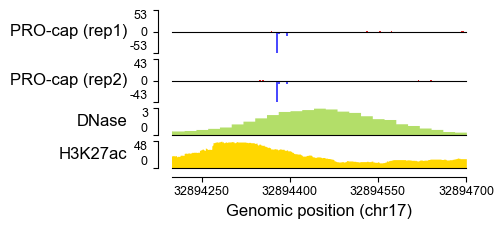

In [40]:
chrom, start, end = e
# chrom, start, end = crispr_region
region = f"{chrom}:{start}-{end}"
outputfile = f"{PROJECT_DIR_o}figures/Fig3d.bottom.pdf"
plot_example(region, outputfile)